# Generative Models

## GAN

By Alireza Heidari

In this notebook, we are going to implement Generative Adversarial Network (GAN) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each generative model.

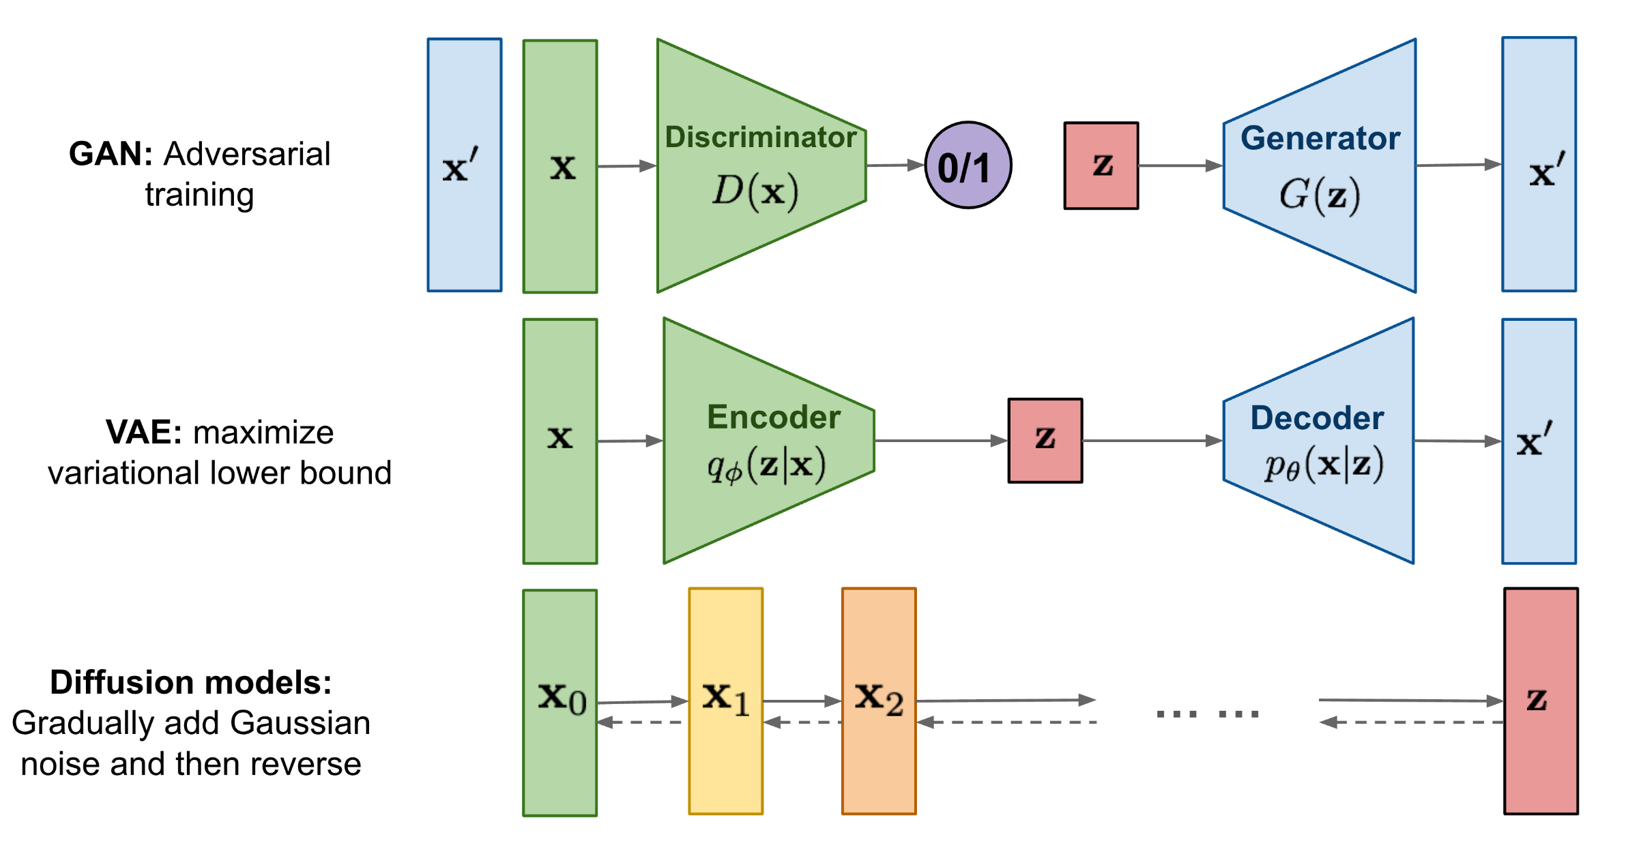 

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images.

### Initialization

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm import tqdm

BATCH_SIZE = 20
IMG_SIZE = 32 
C_IN = 1 # Number of input channels

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [2]:
DEVICE

'cuda'

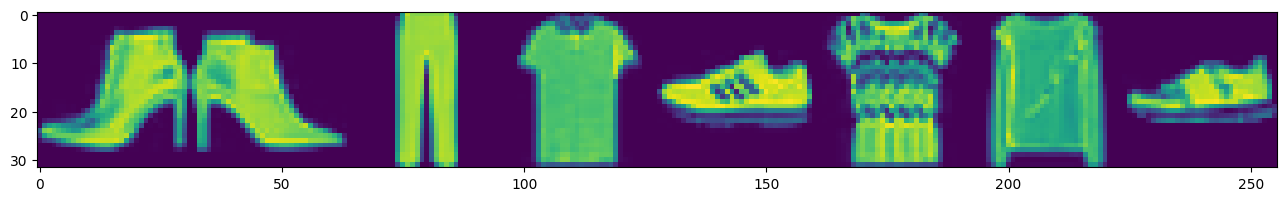

In [3]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

### GAN

GAN's architecture consists of a Discriminator and a Generator. The Discriminator identifies whether an input image ($x$) is real or generated by the Generator. The Generator tries to create fake images given a random noise ($z$) such that the Discriminator can not distinguish them from the real images. These functionalities give rise to an adversarial situation where these networks can be seen as players. Thus, the standard loss for GAN is the following min-max loss. The Generator tries to minimize it, while the Discriminator tries to maximize it.

$$ \min_{\theta_g} \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

We try to optimize this loss function by alternating between the following objectives for the Discriminator and the Generator:
+ Discriminator's objective:
 $$ \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$
+ Generator's objective:
$$ \min_{\theta_g} E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

Each player’s cost depends on the parameters of the other player. However, each
player can only optimize its own parameters.

### ❓ **Question**

> **What are the challenges in this optimization process? How do they address each of these challenges?**

- **Mode Collapse**: Mode collapse occurs when the generator produces a limited set of output samples that do not cover the full distribution of the input data. This can be addressed by using techniques such as minibatch discrimination, adding noise to the input or output, and using different types of loss functions, such as Wasserstein GAN or the hinge loss.

- **Vanishing Gradients**: Vanishing gradients can occur when the gradients passed from the discriminator to the generator become very small, which can slow down or even halt the training process. This can be addressed by using techniques such as batch normalization, weight clipping, and gradient penalty.

- **Unstable Training**: GANs can be unstable to train, as the generator and discriminator networks are trained in an adversarial manner. This can lead to oscillations or divergence in the training process. This can be addressed by using techniques such as gradient penalty, spectral normalization, and progressive growing of the GAN.

- **Evaluation**: Evaluating the performance of GANs is not straightforward, as there is no single metric that can capture the quality of the generated samples. This can be addressed by using a combination of metrics, such as the Frechet Inception Distance (FID), Inception Score, and Precision and Recall.

- **Hyperparameter Tuning**: GANs have many hyperparameters that need to be carefully tuned to achieve good performance, such as the learning rate, weight decay, batch size, and architecture. This can be addressed by using techniques such as grid search, random search, and Bayesian optimization to find the optimal hyperparameters.

- **Data Diversity**: GANs can struggle with data diversity, as the generator may not be able to capture the full diversity of the input data. This can be addressed by using techniques such as conditional GAN, where the generator is conditioned on additional information such as labels or class information.

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, output_channels=1, input_size=32):
        super(Generator, self).__init__()
        self.input_dim = latent_dim
        self.output_channels = output_channels
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.conv_tr = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.conv_tr(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

### Training

In [5]:
class GANManager():
    def __init__(self, img_size=32, latent_dim=64, hidden_dim=128, lr=0.0001):
        
        self.latent_dim = latent_dim
        self.generator = Generator(latent_dim=latent_dim).to(DEVICE)
        self.discriminator = Discriminator().to(DEVICE)

        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.loss = nn.BCELoss()

    def train(self, dataloader, epochs=30, sample_interval=937):

        history = dict(g_loss=[], d_loss=[])
        for epoch in range(epochs):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)
                # Train Discriminator
                self.optimizer_D.zero_grad()

                # Real data
                real_labels = torch.ones(batch_x.size(0), 1, device=DEVICE)
                real_pred = self.discriminator(batch_x)
                real_loss = self.loss(real_pred, real_labels)

                # Fake data
                noise = torch.randn(batch_x.size(0), self.latent_dim, device=DEVICE)
                fake_labels = torch.zeros(batch_x.size(0), 1, device=DEVICE)
                fake_pred = self.discriminator(self.generator(noise).detach())
                fake_loss = self.loss(fake_pred, fake_labels)

                # Total loss
                discriminator_loss = real_loss + fake_loss
                discriminator_loss.backward()
                self.optimizer_D.step()

                # Train Generator
                self.optimizer_G.zero_grad()

                noise = torch.randn(batch_x.size(0), self.latent_dim, device=DEVICE)
                fake_labels = torch.ones(batch_x.size(0), 1, device=DEVICE)
                fake_pred = self.discriminator(self.generator(noise))
                generator_loss = self.loss(fake_pred, fake_labels)
                generator_loss.backward()
                self.optimizer_G.step()
                
                total_g_loss.append(generator_loss.item())
                total_d_loss.append(discriminator_loss.item())

                if (i+1) % sample_interval == 0:
                    self.sample(n=8, plot=True)

            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, epochs, mean_d_loss, mean_g_loss)
            )
            
            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, plot=True):
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim, device=DEVICE)
            gen_imgs = self.generator(z)
            if plot:
                plot_images(gen_imgs)
            self.generator.train()
            return gen_imgs

  0%|          | 0/937 [00:00<?, ?it/s]

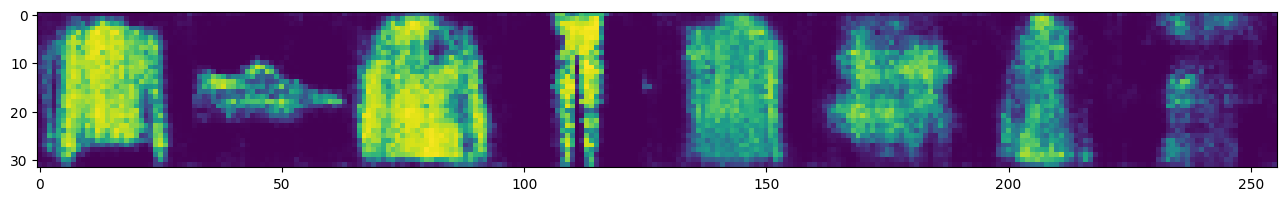

[Epoch: 1/25] [D loss: 0.6951] [G loss: 1.6357]


  0%|          | 0/937 [00:00<?, ?it/s]

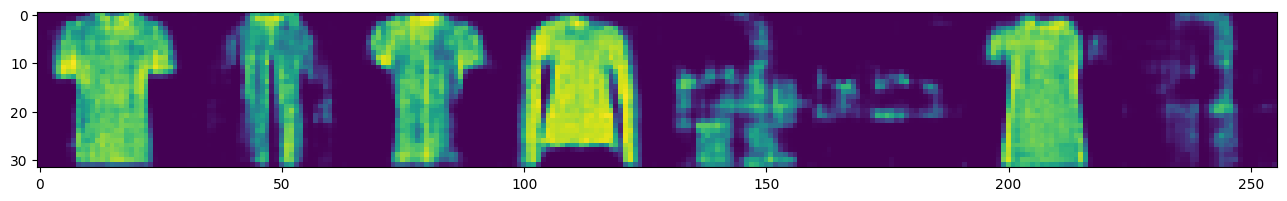

[Epoch: 2/25] [D loss: 0.7630] [G loss: 1.6291]


  0%|          | 0/937 [00:00<?, ?it/s]

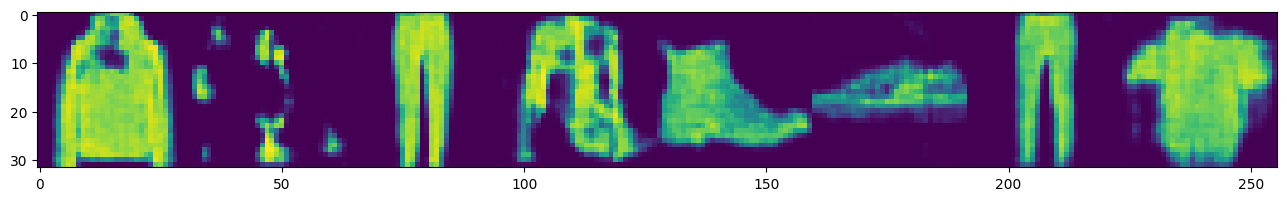

[Epoch: 3/25] [D loss: 0.6311] [G loss: 1.9635]


  0%|          | 0/937 [00:00<?, ?it/s]

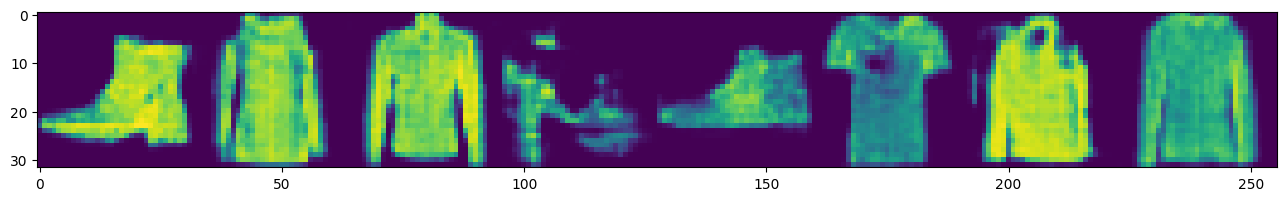

[Epoch: 4/25] [D loss: 0.4805] [G loss: 2.3971]


  0%|          | 0/937 [00:00<?, ?it/s]

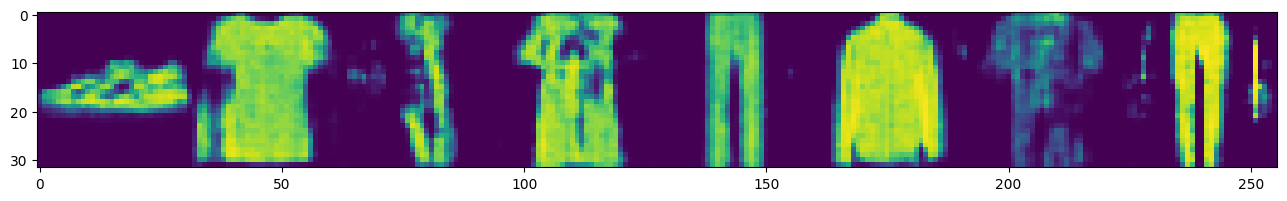

[Epoch: 5/25] [D loss: 0.3780] [G loss: 2.8105]


  0%|          | 0/937 [00:00<?, ?it/s]

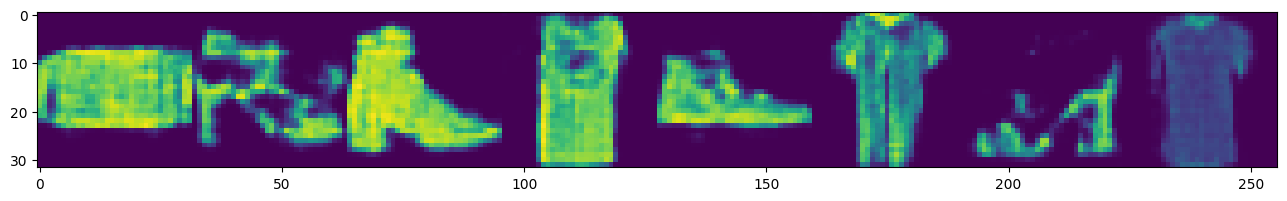

[Epoch: 6/25] [D loss: 0.3183] [G loss: 3.1507]


  0%|          | 0/937 [00:00<?, ?it/s]

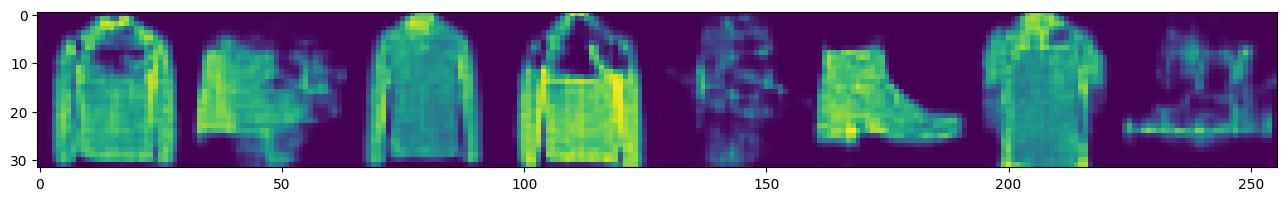

[Epoch: 7/25] [D loss: 0.2619] [G loss: 3.4830]


  0%|          | 0/937 [00:00<?, ?it/s]

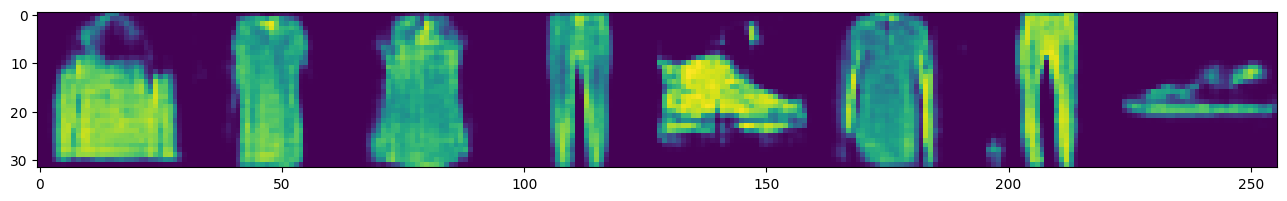

[Epoch: 8/25] [D loss: 0.2368] [G loss: 3.7845]


  0%|          | 0/937 [00:00<?, ?it/s]

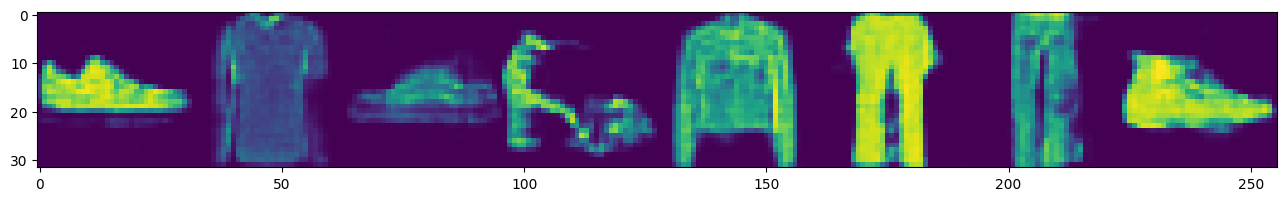

[Epoch: 9/25] [D loss: 0.2232] [G loss: 3.9241]


  0%|          | 0/937 [00:00<?, ?it/s]

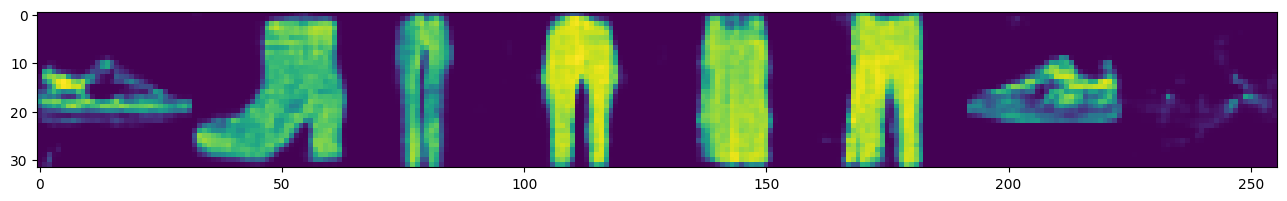

[Epoch: 10/25] [D loss: 0.2026] [G loss: 4.0759]


  0%|          | 0/937 [00:00<?, ?it/s]

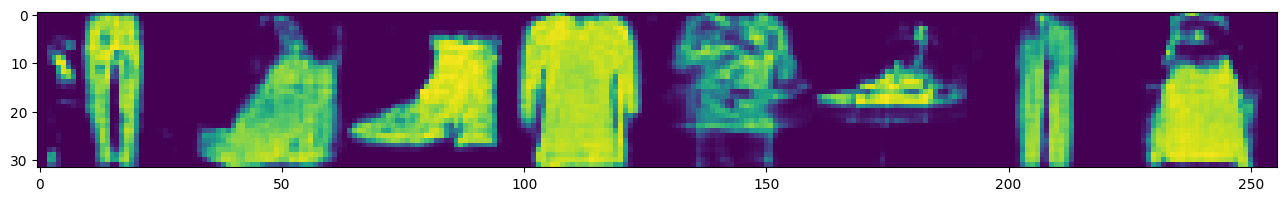

[Epoch: 11/25] [D loss: 0.1750] [G loss: 4.3627]


  0%|          | 0/937 [00:00<?, ?it/s]

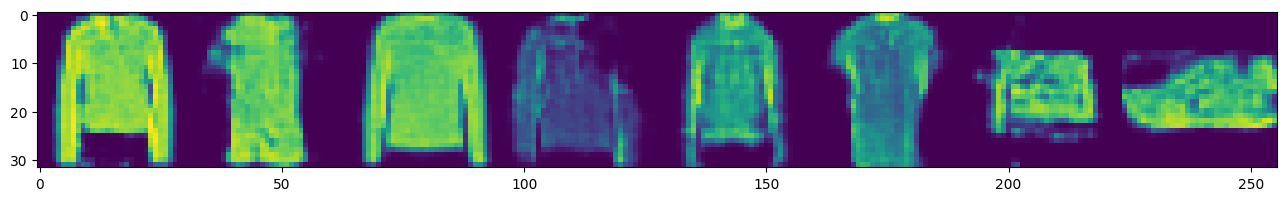

[Epoch: 12/25] [D loss: 0.1800] [G loss: 4.4037]


  0%|          | 0/937 [00:00<?, ?it/s]

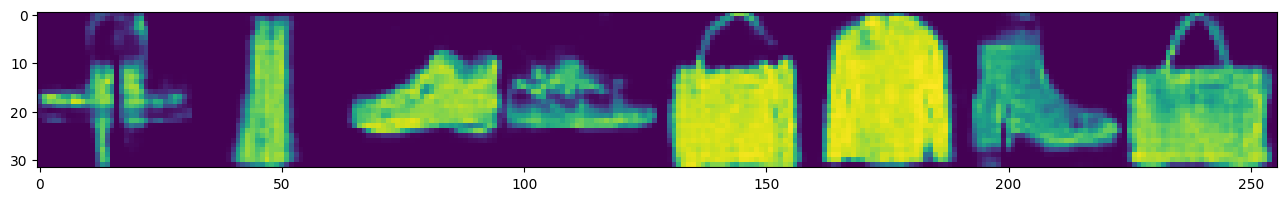

[Epoch: 13/25] [D loss: 0.1637] [G loss: 4.5831]


  0%|          | 0/937 [00:00<?, ?it/s]

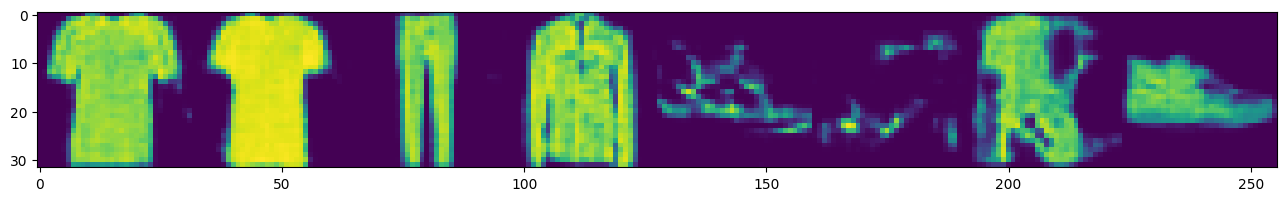

[Epoch: 14/25] [D loss: 0.1569] [G loss: 4.7149]


  0%|          | 0/937 [00:00<?, ?it/s]

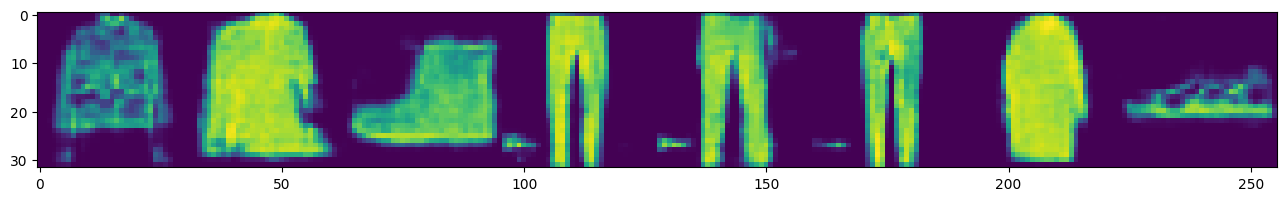

[Epoch: 15/25] [D loss: 0.1342] [G loss: 4.9001]


  0%|          | 0/937 [00:00<?, ?it/s]

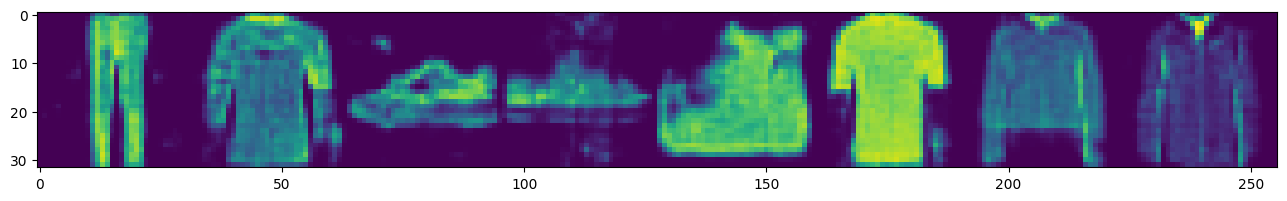

[Epoch: 16/25] [D loss: 0.1553] [G loss: 4.8752]


  0%|          | 0/937 [00:00<?, ?it/s]

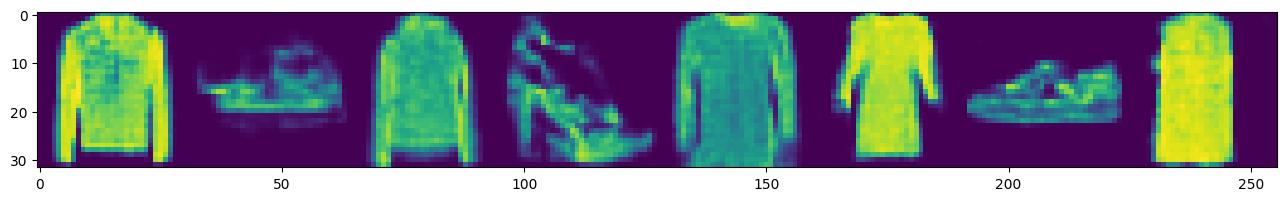

[Epoch: 17/25] [D loss: 0.1397] [G loss: 5.0545]


  0%|          | 0/937 [00:00<?, ?it/s]

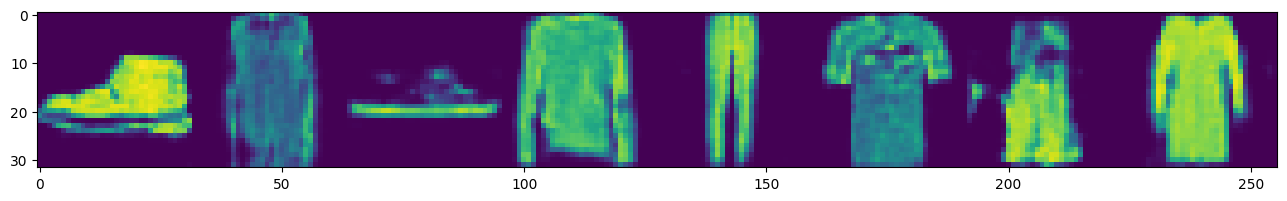

[Epoch: 18/25] [D loss: 0.1243] [G loss: 5.1205]


  0%|          | 0/937 [00:00<?, ?it/s]

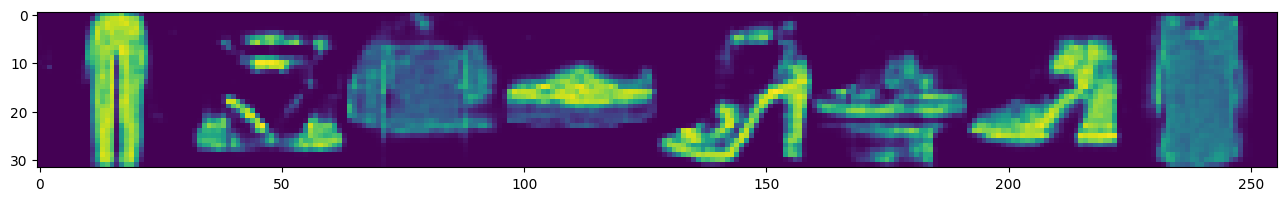

[Epoch: 19/25] [D loss: 0.1307] [G loss: 5.2478]


  0%|          | 0/937 [00:00<?, ?it/s]

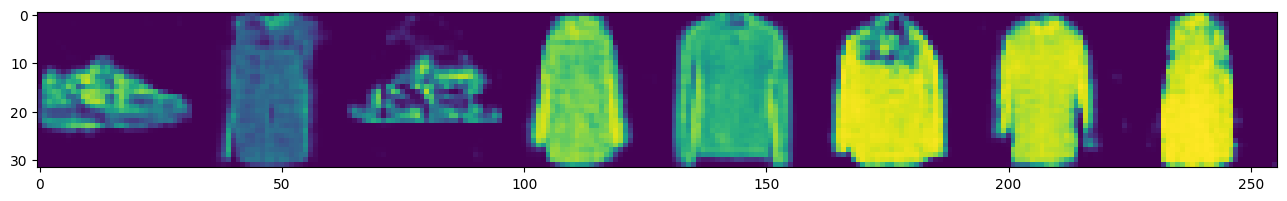

[Epoch: 20/25] [D loss: 0.1126] [G loss: 5.2719]


  0%|          | 0/937 [00:00<?, ?it/s]

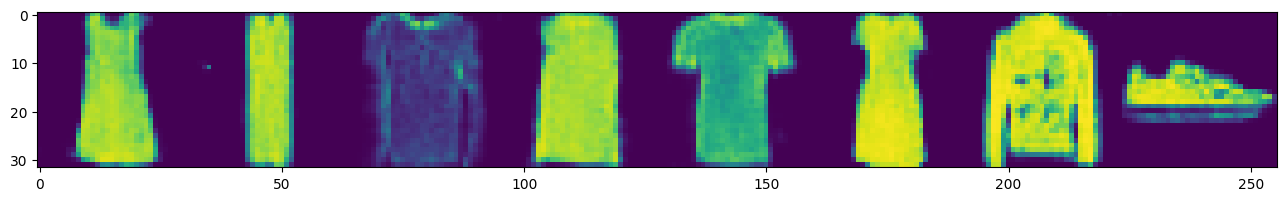

[Epoch: 21/25] [D loss: 0.1138] [G loss: 5.4040]


  0%|          | 0/937 [00:00<?, ?it/s]

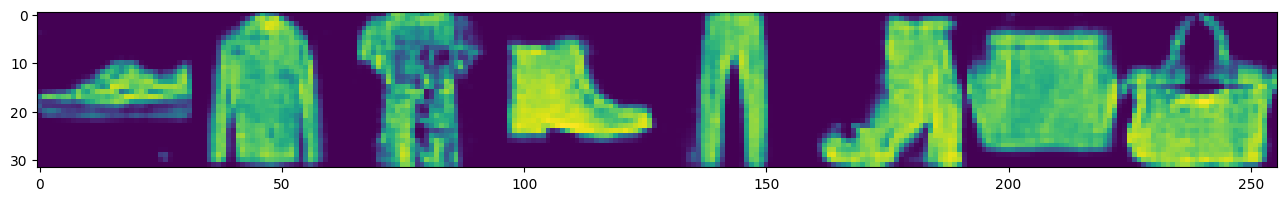

[Epoch: 22/25] [D loss: 0.1034] [G loss: 5.5218]


  0%|          | 0/937 [00:00<?, ?it/s]

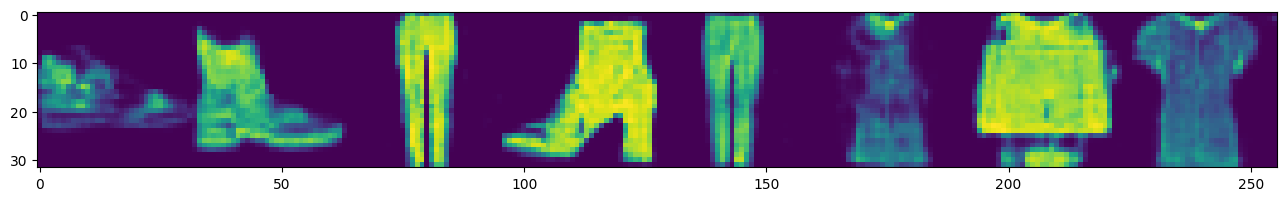

[Epoch: 23/25] [D loss: 0.1105] [G loss: 5.5474]


  0%|          | 0/937 [00:00<?, ?it/s]

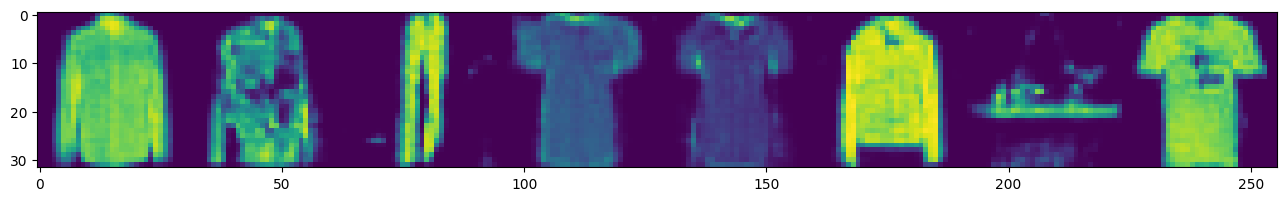

[Epoch: 24/25] [D loss: 0.1131] [G loss: 5.5037]


  0%|          | 0/937 [00:00<?, ?it/s]

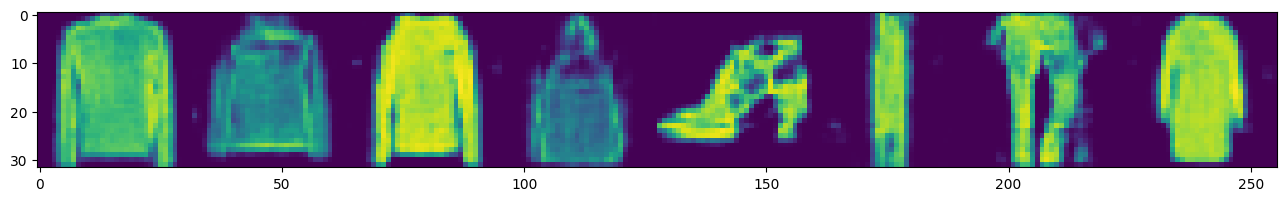

[Epoch: 25/25] [D loss: 0.0883] [G loss: 5.7938]


In [ ]:
gan = GANManager(
    img_size=32,
    latent_dim=64,
    hidden_dim=256,
    lr=0.0002,
)
gan_history = gan.train(dataloader, epochs=25, sample_interval=937)

### ❓ **Question**
> - **How can we generate images from a specific class in GAN?** 

To generate images from a specific class in a GAN, we can add a conditioning variable to the generator and the discriminator, which encodes (Embedding) the class label of the image we want to generate. This conditioning variable can be concatenated with the noise vector in the generator and with the image tensor in the discriminator, during training.

### Visualize Loss

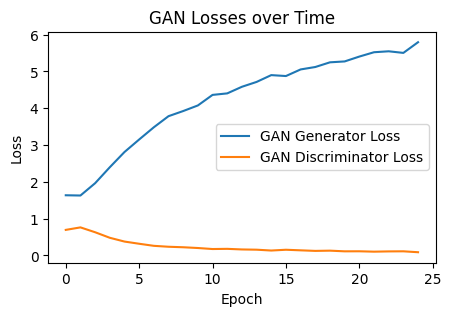

In [7]:
def plot_losses(gan_history):
    figsize = (5, 3)
    plt.figure(figsize=figsize)
    plt.plot(gan_history['g_loss'], label='GAN Generator Loss')
    plt.plot(gan_history['d_loss'], label='GAN Discriminator Loss')
    plt.title('GAN Losses over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(gan_history)